300


Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.031217444255383614
<<<<<< ⚡️ cuda is used >>>>>>


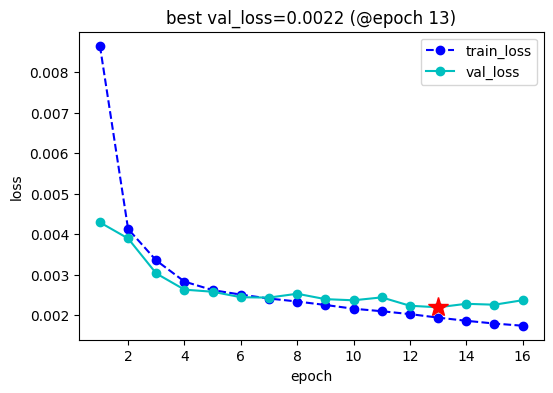

<<<<<< val_loss without improvement in 3 epoch,early stopping >>>>>> 



In [2]:
model_name = "chatglm3-6b"
eval_before_finetune=False
finetune=True
eval_after_finetune=False
ckpt_path='0502_60day_paraunfix'
eval_model_path='finetune_model_0325_3000'

import pandas as pd
import numpy as np
import datasets
import sys
#读数据
import json
file=open('data_60.json','r',encoding='utf-8')
papers = []
dataLength=0
for line in file.readlines():
    dic = json.loads(line)
    papers.append(dic)
    dataLength+=1
#df = pd.DataFrame(columns='')
days=60
tmp_big=[]
for i in range(dataLength):
    tmp_small=[]
    a=papers[i]
    #print(type(a))
    tmp_small.append(a['conversations'][0]['content'])
    tmp_small.append(a['conversations'][1]['content'])
    tmp_big.append(tmp_small)
df = pd.DataFrame(tmp_big, columns=['text', 'tag'])

# 将Pandas DataFrame对象转换为Hugging Face Dataset对象
# 将数据集划分为训练集和测试集
# test_size: 指定测试集的大小。在这个例子中，测试集的大小是2000，这意味着2000个样本将被用于测试集
# 已知完整的数据集一共包括8000个案例，因此有6000个训练集
# shuffle: 如果设置为True，数据集在划分之前会被打乱，可以确保训练集和测试集是随机抽样的，从而避免因样本排序引起的偏差
# seed: 设置随机数生成器的种子，用于控制随机打乱的过程，确保结果是可复制的。在这里，种子被设置为43，你也可以设置为其他的数字
ds_dic = datasets.Dataset.from_pandas(df).train_test_split(
    test_size =days*5,shuffle=False, seed = 43)

dftrain = ds_dic['train'].to_pandas() # 将训练集转化为pandas
dftest = ds_dic['test'].to_pandas() # 将验证集转化为pandas
# 用于将DataFrame对象保存为Parquet格式的文件
dftrain.to_parquet('dftrain.parquet')
dftest.to_parquet('dftest.parquet')

preds = ['' for x in dftest['tag']] # 基于测试集的长度创建一个新的数组，用于存储测试的结果
print(len(preds))
dftest['pred'] = preds
#print(dftest)
dftest.to_parquet('dftest.parquet')

data_test=dftest
data_train=dftrain

#加载微调之前的模型
import torch
if eval_before_finetune==True:
    import os
    import platform
    from transformers import AutoTokenizer, AutoModel
    MODEL_PATH = os.environ.get('MODEL_PATH', model_name)
    #MODEL_PATH = os.environ.get('MODEL_PATH', '../chatglm3-6b')
    TOKENIZER_PATH = os.environ.get("TOKENIZER_PATH", MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, trust_remote_code=True)
    model = AutoModel.from_pretrained(MODEL_PATH, trust_remote_code=True, device_map="auto").eval().half().cuda()

from tqdm import tqdm

acc_list = []
if eval_before_finetune == True:
    for kk in range(1):
        # import torch
        i1 = 1
        for i in tqdm(range(len(dftest))):
            if i == 0:
                prompt = dftest['text'].loc[0]
                prompt_next = dftest['text'].loc[1]
                cutPoint1 = prompt_next.find('第2天')
                cutPoint2 = prompt_next.find('今天的需求')
                cutPoint3 = prompt_next.find('剩余资源总量', cutPoint1, cutPoint2)
                cutPoint4 = prompt_next.find('剩余运输经费', cutPoint1, cutPoint2)
                cutPoint5 = prompt_next.find('决策结果', cutPoint1, cutPoint2)
                b1 = int(prompt_next[cutPoint3 + 6:cutPoint4 - 1])
                b2 = int(prompt_next[cutPoint4 + 6:cutPoint5 - 1])

            elif i == 1:
                cutPoint1 = prompt.find('今天的需求')
                promptToday = dftest['text'].loc[i]

                cutPoint2 = promptToday.find('今天的需求')
                cutPoint3 = promptToday.find('第' + str(i + 1) + '天')
                cutPoint4 = promptToday.find('剩余资源总量', cutPoint3, cutPoint2)

                # cutPoint5 = promptToday.find('第' + str(i+1) + '天需求')
                cutPoint6 = promptToday.find('需求', cutPoint3, cutPoint2)
                cutPoint7 = promptToday.find('运输费用', cutPoint3, cutPoint2)
                cutPoint8 = promptToday.find('掠夺后实际', cutPoint3, cutPoint2)
                b1x = int(promptToday[cutPoint6 + 2:cutPoint7 - 1])
                b2x = int(promptToday[cutPoint7 + 4:cutPoint8 - 1])
                cutPoint9 = promptToday.find('剩余资源总量', cutPoint2)
                cutPoint10 = promptToday.find('请根据历史', cutPoint2)
                decesion_tuple = {'是': 1, '否': 0}
                b1 = b1 - (b1x * decesion_tuple[response])
                b2 = b2 - (b2x * decesion_tuple[response])
                b3 = b1
                b4 = b2
                prompt = (prompt[0:cutPoint1] + promptToday[cutPoint3:cutPoint2 - 2] + response +
                          promptToday[cutPoint2 - 1:cutPoint9 + 6] + str(b1) + ',剩余运输经费' + str(b2) + promptToday[
                                                                                                           cutPoint10 - 1:])

            else:
                cutPoint1 = prompt.find('今天的需求')
                promptToday = dftest['text'].loc[i]
                cutPoint2 = promptToday.find('今天的需求')
                cutPoint3 = promptToday.find('第' + str(i + 1) + '天')
                cutPoint4 = promptToday.find('剩余资源总量', cutPoint3, cutPoint2)
                # cutPoint5 = promptToday.find('第' + str(i+1) + '天需求')
                cutPoint6 = promptToday.find('需求', cutPoint3, cutPoint2)
                cutPoint7 = promptToday.find('运输费用', cutPoint3, cutPoint2)
                cutPoint8 = promptToday.find('掠夺后实际', cutPoint3, cutPoint2)
                b1x = int(promptToday[cutPoint6 + 2:cutPoint7 - 1])
                b2x = int(promptToday[cutPoint7 + 4:cutPoint8 - 1])
                cutPoint9 = promptToday.find('剩余资源总量', cutPoint2)
                decesion_tuple = {'是': 1, '否': 0, '\'是\'': 1, '\'否\'': 0}
                try:
                    b1 -= (b1x * decesion_tuple[response])
                    b2 -= (b2x * decesion_tuple[response])
                except:
                    b1 = b1
                    b2 = b2
                prompt = (prompt[0:cutPoint1] + promptToday[cutPoint3:cutPoint4 + 6] + str(b3) + ',剩余运输经费' + str(
                    b4) + ',决策结果:' + response +
                          promptToday[cutPoint2 - 1:cutPoint9 + 6] + str(b1) + ',剩余运输经费' + str(
                            b2) + ',请根据历史和今天的信息进行决策,输出当天的决策结果,仅用一个字\'是\'或\'否\'表示今天的决策结果.')
                b3 = b1
                b4 = b2
            # print(prompt)
            response, _ = model.chat(tokenizer, prompt)

            # print(i,response)
            preds[i] = response
        # print(preds)
        # torch.cuda.empty_cache()
        dftest['pred'] = preds
        # 创建 dftest 的数据透视表
        # index='tag': 将'dftest'数据集的'tag'列设置为透视表的索引（行标签）
        # columns='pred': 将数据集的'pred'列设置为透视表的列标签
        # values='text': 将数据集的'text'列的值填充到透视表中。一般来说，我们会选择一个需要进行计算的列作为values
        # aggfunc='count': 聚合函数，定义了我们如何对values进行计算。在这里，我们选择的是'count'，意味着我们要对'text'列的值进行计数
        # dftest.pivot_table(index='tag',columns = 'pred',values='text',aggfunc='count')
        # print(dftest)
        dftest.pivot_table(index='tag', columns='pred', values='text', aggfunc='count')
        acc = len(dftest.query('tag==pred')) / len(dftest)  # 没有经过ft的model的accuracy为0.4分数不高也不低
        # print('accuracy=',acc)
        acc_list.append(acc)
    print(acc_list)

if eval_before_finetune==True:
    print(sum(acc_list)/len(acc_list))
#print(len(dftest.query('tag==pred'))/len(dftest))
    print(dftest)
#print(preds)
#print(dftest.loc[33,'text'])


#清空torch占用
if eval_before_finetune==True:
    tokenizer=None
    model = None
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
# 加载数据
import pandas as pd
import numpy as np
#import datasets

dftrain = pd.read_parquet('dftrain.parquet')
dftest = pd.read_parquet('dftest.parquet')


dftrain['context'] = [x for x in dftrain['text']]
dftrain['target'] = [x for x in dftrain['tag']] # 定义训练集中的标签
dftrain = dftrain[['context','target']]

dftest['context'] = [x for x in dftest['text']]
dftest['target'] = [x for x in dftest['tag']]
dftest = dftest[['context','target']]

# 将pandas的dataset转化为hf的dataset
ds_train = datasets.Dataset.from_pandas(dftrain)
ds_val = datasets.Dataset.from_pandas(dftest)

# 将输入的文本转化为token也就是Tokenizer
# context转化成context_ids，把target转化成target_ids
# 将context_ids和target_ids拼接到一起作为模型的input_ids

from tqdm import tqdm
import transformers


max_seq_length = 5000
skip_over_length = True
if finetune==True:
# 载入模型的Tokenizer
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 载入模型的参数
    config = transformers.AutoConfig.from_pretrained(model_name, trust_remote_code=True, device_map='auto')

# 定义预处理流程
def preprocess(example):
    context = example["context"]
    target = example["target"]
    # 将context转化为id 超长就截取
    context_ids = tokenizer.encode(
            context,
            max_length=max_seq_length,
            truncation=True)
    # 将target也转化为id
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    # 将上述两者的id拼接 + 配置文件中end of sentence 的id
    input_ids = context_ids + target_ids + [config.eos_token_id]

    return {"input_ids": input_ids, "context_len": len(context_ids),'target_len':len(target_ids)}

# 先进行preprocess流程，然后基于该流程的结果选择三个列
if finetune==True:
    ds_train_token = ds_train.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
'''
if skip_over_length: # 基于跳过超长输入内容的条件，将训练集中太长的数据进行剔除
    ds_train_token = ds_train_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)'''
# 逻辑和上面一致，对验证集的处理
if finetune==True:
    ds_val_token = ds_val.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
'''if skip_over_length:
    ds_val_token = ds_val_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)'''

import torch
# 把一个batch的数据整理成适合模型训练的格式
# 这里需要注意的是训练的思路，输入的信息是上下文 + 结论 + 句号 + padding，但是做loss的部分只有结论的部分 + 句号的部分也就是 target_id + eos_id
def data_collator(features: list):
    len_ids = [len(feature["input_ids"]) for feature in features]
    # 计算出这个batch中的所有样本的 input_ids 长度，并找出最长的长度
    # 之后按照batch中最长的input_ids进行padding，不足的就用空补全
    longest = max(len_ids)
    # 初始化两个空列表 input_ids 和 labels_list，它们用于存储预处理后的输入数据和标签数据
    input_ids = []
    labels_list = []
    # 对 len_ids 和 features 进行合并，然后按照 input_ids 的长度进行逆序排序，也就是说，最长的 input_ids 会排在前面
    for length, feature in sorted(zip(len_ids, features), key=lambda x: -x[0]):
        # 提取出当前样本的 input_ids 和 context_len
        ids = feature["input_ids"]
        context_len = feature["context_len"]
        # 生成标签数据
        # -100 是一个特殊的标记，它表示该位置的损失会在训练时被忽略
        # 标签数据的生成规则：先放入 context_len  个 -100，然后放入 ids 从 context_len 开始到最后的部分，最后再放入 longest - length 个 -100
        labels = (
            [-100] * context_len + ids[context_len :] + [-100] * (longest - length)
        ) #-100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
        # 对 input_ids 进行padding，如果 input_ids 的长度小于最长长度，那么在其后面添加足够数量的 pad_token_id
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        # 将处理过的 input_ids 和 labels 转为 LongTensor 类型，然后添加到相应的列表中
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labels))

    # 将 input_ids 和 labels 的列表堆叠为一个新的tensor
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }

# ds_train_token 是送入训练的数据集
# num_workers 是数据载入时将使用多线程并行处理，这可以在一定程度上加速数据载入
# batch_size 是每一个批次的样本数量
# pin_memory=True: 如果设为 True，那么数据载入器将会在返回Tensor之前，先将其复制到CUDA固定内存中。这样可以使得转移数据到GPU上更快
# shuffle=True: 如果设为 True，那么在每个训练周期开始时，数据载入器将会打乱数据集的顺序
# collate_fn=data_collator: 这个函数定义了如何将多个样本合并成一个小批量。在这里，我们使用之前定义的 data_collator 函数，这个函数会按照我们的需要对每个小批量的数据进行预处理
if finetune==True:
    dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=1,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)
    dl_val = torch.utils.data.DataLoader(ds_val_token,num_workers=2,batch_size=1,
                                    pin_memory=True,shuffle=True,
                                     collate_fn = data_collator)

import warnings
warnings.filterwarnings("ignore")
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

# 加载ChatGLM2-6B模型并不以8bit的精度载入
if finetune==True:
    model = AutoModel.from_pretrained(model_name,load_in_4bit=True,trust_remote_code=True,device_map='auto')
    '''
    model.supports_gradient_checkpointing = True  #节约cuda，但可能会使得训练时间变长
    model.gradient_checkpointing_enable() # 作用同上
    model.enable_input_require_grads() # 作用同上
    '''
    model.config.use_cache = False  # 关闭了模型的缓存机制，该设置可以避免一些警告，但在模型推理时需要重新开启

# 配置LORA模型的类
# 常规LM任务
# 非推理模式
    peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
)

# 结合Lora和原有模型
    model = get_peft_model(model, peft_config)
# 开启模型的并行处理能力，这可以在有多个GPU的情况下提高训练效率
    model.is_parallelizable =  True
    model.model_parallel = True
# 打印出模型的可训练参数
    model.print_trainable_parameters()
# 可训练参数：1949696
# 总参数量：6245533696
# 需要调整的模型参数量的占比还是很低的 3.1%

from torchkeras import KerasModel
from accelerate import Accelerator


# 重写了torchkeras中的StepRunner类
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage="train", metrics_dict=None,
                 optimizer=None, lr_scheduler=None
                 ):
        self.net, self.loss_fn, self.metrics_dict, self.stage = net, loss_fn, metrics_dict, stage
        self.optimizer, self.lr_scheduler = optimizer, lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
        if self.stage == 'train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch_list):

        # 计算loss
        with self.accelerator.autocast():
            # 通过模型self.net对输入数据进行预测，然后用预测结果和标签计算损失, loss的计算过程直接交给ChatGLM2了吗？
            loss_remember=0
            accu_iter=len(batch_list)
            for i in range(accu_iter):
                batch=batch_list[i]
                loss=self.net(input_ids=batch["input_ids"], labels=batch["labels"]).loss
                loss=loss/accu_iter
                loss_remember += loss.item()
                if self.optimizer is not None and self.stage == "train":
                    self.accelerator.backward(loss)
        # 执行梯度下降的步骤
        if self.optimizer is not None and self.stage == "train":
            # 计算每个模型参数关于损失的梯度

            # 执行梯度裁剪（self.accelerator.clip_grad_norm_），防止梯度爆炸
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            # 更新模型参数
            self.optimizer.step()
            # 存在学习率调整器，就调整学习率
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            # 清空梯度
            self.optimizer.zero_grad()
            


        # losses (or plain metrics that can be averaged)
        step_losses = {self.stage + "_loss":loss_remember}

        # metrics (stateful metrics)
        step_metrics = {}

        # 记录过程信息，追踪模型性能用
        if self.stage == "train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        torch.cuda.empty_cache()

        return step_losses, step_metrics


KerasModel.StepRunner = StepRunner


class EpochRunner:
    def __init__(self, steprunner, quiet=False):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.accelerator = steprunner.accelerator
        self.net = steprunner.net
        self.quiet = quiet

    def __call__(self, dataloader):
        n = dataloader.size if hasattr(dataloader, 'size') else len(dataloader)
        loop = tqdm(enumerate(dataloader, start=1),
                    total=n,
                    file=sys.stdout,
                    disable=not self.accelerator.is_local_main_process or self.quiet,
                    ncols=100
                    )
        epoch_losses = {}

        batch_list=[]
        for step, batch in loop:
            with self.accelerator.accumulate(self.net):
                if step % days != 0:
                    batch_list.append(batch)
                    continue
                else:
                    batch_list.append(batch)
                    step_losses, step_metrics = self.steprunner(batch_list)
                    batch_list=[]
                step_log = dict(step_losses, **step_metrics)
                for k, v in step_losses.items():
                    epoch_losses[k] = epoch_losses.get(k, 0.0) + v

                if step < n:
                    loop.set_postfix(**step_log)

                    if hasattr(self, 'progress') and self.accelerator.is_local_main_process:
                        post_log = dict(**{'i': step, 'n': n}, **step_log)
                        self.progress.set_postfix(**post_log)

                elif step == n:
                    epoch_metrics = step_metrics
                    epoch_metrics.update({self.stage + "_" + name: metric_fn.compute().item()
                                          for name, metric_fn in self.steprunner.metrics_dict.items()})
                    epoch_losses = {k: v / step for k, v in epoch_losses.items()}
                    epoch_log = dict(epoch_losses, **epoch_metrics)
                    loop.set_postfix(**epoch_log)

                    if hasattr(self, 'progress') and self.accelerator.is_local_main_process:
                        post_log = dict(**{'i': step, 'n': n}, **epoch_log)
                        self.progress.set_postfix(**post_log)

                    for name, metric_fn in self.steprunner.metrics_dict.items():
                        metric_fn.reset()
                else:
                    break
        return epoch_log

KerasModel.EpochRunner = EpochRunner




# 仅仅保存lora可训练参数
# 覆盖了KerasModel中的load_ckpt和save_ckpt方法
def save_ckpt(self, ckpt_path='checkpoint', accelerator=None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path, safe_serialization=False)


def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path, 'adapter_model.bin')), strict=False)
    self.from_scratch = False


KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt


from torchkeras import KerasModel
# 定义模型的训练
# 没有损失函数
# 优化器是adamW
# 学习率 2e-6
# 模型参数存储路径
if finetune==True:
    keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=6e-6))
#ckpt_path = 'finetune_model'


# 训练一百轮
# patience=5：早停策略的参数，用于防止模型在训练过程中过拟合。如果在连续的5轮训练中，验证损失（或者其他的指定指标）都没有改善，那么训练将会提前停止
# monitor='val_loss'：需要监控的指标：验证损失
# mode='min'：早停策略的参数，指定了改进的方向。'min'意味着指标（这里是验证损失）的最小值被视为改进
# mixed_precision='fp16'：这是一种混合精度训练的策略。在混合精度训练中，一部分张量的数据类型会被设为低精度（如半精度浮点数fp16），这样可以减少计算资源的需求，从而提高训练速度和效率
if finetune == True:
    keras_model.fit(
        train_data=dl_train,
        val_data=dl_val,
        epochs=30, patience=3,
        monitor='val_loss', mode='min',
        ckpt_path=ckpt_path,
        mixed_precision='fp16'
    )
